In [1]:
import warnings

from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()
warnings.filterwarnings('ignore')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from nltk.tokenize.casual import casual_tokenize

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import (
    LatentDirichletAllocation,
    TruncatedSVD,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import (
    SVC,
    LinearSVC,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    homogeneity_score,
    completeness_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
)
from skopt import BayesSearchCV
from catboost import CatBoostClassifier

DATASET_PATH = "../data/stemming_post_texts.csv"
NGRAM_RANGE = (1,1)
N_SAMPLES = 20000

In [3]:
corpus_df = pd.read_csv(DATASET_PATH)

In [4]:
corpus_df.shape

(356565, 2)

In [5]:
corpus_df.isnull().sum()

text         0
sentiment    0
dtype: int64

In [6]:
train_corpus_df = corpus_df.dropna(subset=["text"]).sample(frac=1).reset_index(drop=True)

In [7]:
if N_SAMPLES:
    train_corpus_df = train_corpus_df.sample(N_SAMPLES)

In [8]:
text_documents_list = train_corpus_df.text.to_list()

In [9]:
tf_idf_vectorizer = TfidfVectorizer(tokenizer=casual_tokenize, ngram_range=NGRAM_RANGE, max_features=1000)

In [10]:
%%time
tf_idf_vectorizer.fit(text_documents_list)

CPU times: total: 3.48 s
Wall time: 3.49 s


TfidfVectorizer(max_features=1000,
                tokenizer=<function casual_tokenize at 0x0000028B30798E50>)

In [11]:
%%time
X = tf_idf_vectorizer.transform(train_corpus_df["text"])
y = train_corpus_df["sentiment"]

CPU times: total: 3.03 s
Wall time: 3.04 s


In [12]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [13]:
X.shape

(20000, 1000)

Latent semantic analysis

In [14]:
svd_2_components = TruncatedSVD(n_components=2)

In [15]:
%%time
svd_2_components.fit(X)

CPU times: total: 141 ms
Wall time: 52 ms


TruncatedSVD()

In [16]:
svd_2_data = svd_2_components.transform(X)

In [17]:
svd_2_data_df = pd.DataFrame(data=svd_2_data, columns=["parameter_1", "parameter_2"])
svd_2_data_df["sentiment"] = y
svd_2_data_df["sentiment"] = svd_2_data_df["sentiment"].replace({-1: "negative", 0: "neutral", 1: "positive"})

<AxesSubplot: xlabel='parameter_1', ylabel='parameter_2'>

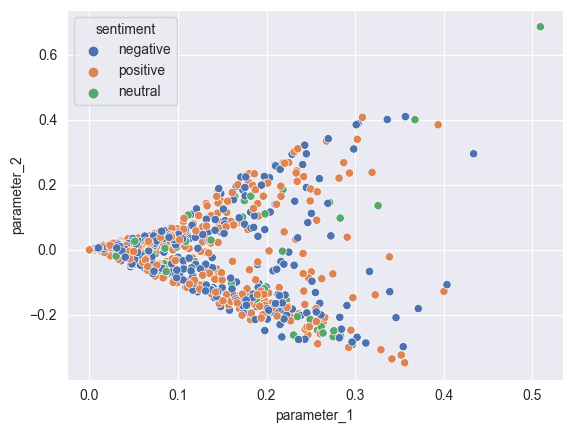

In [18]:
sns.scatterplot(data=svd_2_data_df, x="parameter_1", y="parameter_2",  hue="sentiment", palette="deep")

Latent Dirichlet Decomposition

In [19]:
ldia = LatentDirichletAllocation(n_components=2, learning_method="batch")

In [20]:
%%time
ldia.fit(X)

CPU times: total: 27.1 s
Wall time: 28.1 s


LatentDirichletAllocation(n_components=2)

In [21]:
ldia_2_data = ldia.transform(X)

In [22]:
ldia_2_data_df = pd.DataFrame(data=ldia_2_data, columns=["parameter_1", "parameter_2"])
ldia_2_data_df["sentiment"] = y
ldia_2_data_df["sentiment"] = ldia_2_data_df["sentiment"].replace({-1: "negative", 0: "neutral", 1: "positive"})

<AxesSubplot: xlabel='parameter_1', ylabel='parameter_2'>

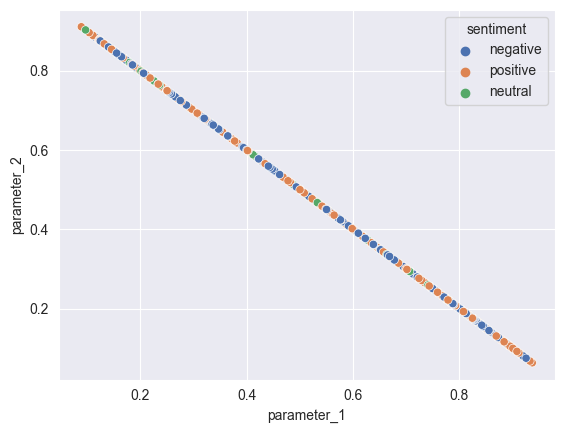

In [23]:
sns.scatterplot(data=ldia_2_data_df, x="parameter_1", y="parameter_2",  hue="sentiment", palette="deep")

K-means

In [24]:
k_means = KMeans(n_clusters=3, init="k-means++", max_iter=150)

In [25]:
%%time
k_means.fit(X)

CPU times: total: 2.91 s
Wall time: 775 ms


KMeans(max_iter=150, n_clusters=3)

In [26]:
k_means_predictions = k_means.predict(X)

In [27]:
k_means_df = pd.DataFrame(data=svd_2_data, columns=["parameter_1", "parameter_2"])
k_means_df["cluster"] = k_means_predictions
k_means_df["cluster"] = k_means_df["cluster"]

In [28]:
k_means_centers = pd.DataFrame(data=svd_2_components.transform(k_means.cluster_centers_), columns=["parameter_1", "parameter_2"])

<AxesSubplot: xlabel='parameter_1', ylabel='parameter_2'>

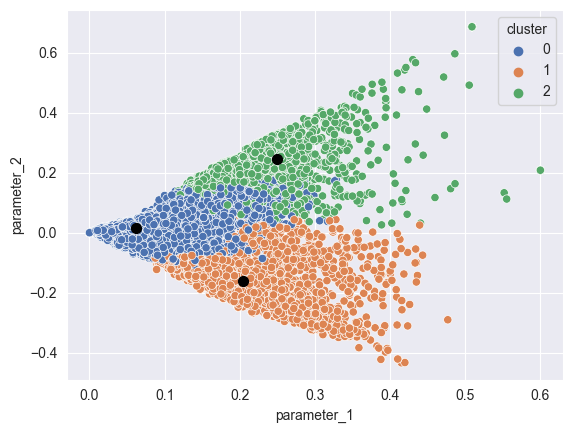

In [29]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=k_means_df, x="parameter_1", y="parameter_2",  hue="cluster", palette="deep")
k_means_centers.plot.scatter(x="parameter_1", y="parameter_2", ax=ax, s=50, color="black")

In [30]:
print(f"Однородность кластеров для K-средних: {homogeneity_score(y, k_means_df.cluster)}")
print(f"Полнота кластеров для K-средних: {completeness_score(y, k_means_df.cluster)}")
print(classification_report(y_encoded, k_means_df.cluster))

Однородность кластеров для K-средних: 0.02375435541442599
Полнота кластеров для K-средних: 0.028085022329375153
              precision    recall  f1-score   support

           0       0.45      0.75      0.57      8653
           1       0.00      0.00      0.00      1397
           2       0.45      0.07      0.13      9950

    accuracy                           0.36     20000
   macro avg       0.30      0.28      0.23     20000
weighted avg       0.42      0.36      0.31     20000



Разделение на обучающие и тестовые данные

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

Наивный байесовский классификатор

In [32]:
naive_bayes_bcv = BayesSearchCV(estimator=MultinomialNB(), search_spaces={
    "alpha": [x / 10 for x in range(0, 11, 1)],
    "fit_prior": [True, False],
}, scoring="f1_weighted", n_jobs=2, verbose=2)

In [33]:
%%time
naive_bayes_bcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=MultinomialNB(), n_jobs=2, scoring='f1_weighted',
              search_spaces={'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                       0.8, 0.9, 1.0],
                             'fit_prior': [True, False]},
              verbose=2)

In [34]:
naive_bayes_model = naive_bayes_bcv.best_estimator_

In [35]:
naive_bayes_model

MultinomialNB(alpha=0.8)

In [36]:
y_pred = naive_bayes_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.60      0.56      0.58      1707
     neutral       0.52      0.57      0.55       282
    positive       0.68      0.70      0.69      2011

    accuracy                           0.63      4000
   macro avg       0.60      0.61      0.60      4000
weighted avg       0.63      0.63      0.63      4000



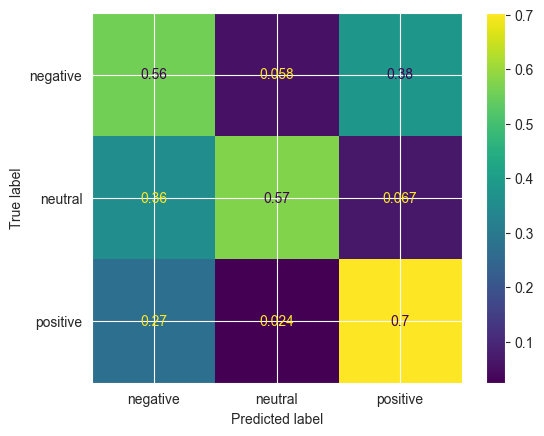

In [37]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [38]:
print(np.mean(cross_val_score(naive_bayes_model, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

0.6272083581702879


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


SVC

In [39]:
%%time

svc_bcv = BayesSearchCV(estimator=SVC(), search_spaces={
    "C": [x / 10 for x in range(1, 11, 1)],
    "max_iter": [x for x in range(10, 1000, 10)],
}, scoring="f1_weighted", n_jobs=2, verbose=2)

svc_bcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=SVC(), n_jobs=2, scoring='f1_weighted',
              search_spaces={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0],
                             'max_iter': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250, 260, 270, 280, 290, 300, ...]},
              verbose=2)

In [40]:
svc = svc_bcv.best_estimator_
svc

SVC(C=0.6, max_iter=870)

In [41]:
%%time
svc.fit(X_train, y_train)

CPU times: total: 4.53 s
Wall time: 4.72 s


SVC(C=0.6, max_iter=870)

In [42]:
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.45      0.84      0.58      1707
     neutral       0.58      0.47      0.52       282
    positive       0.62      0.17      0.27      2011

    accuracy                           0.48      4000
   macro avg       0.55      0.49      0.46      4000
weighted avg       0.54      0.48      0.42      4000



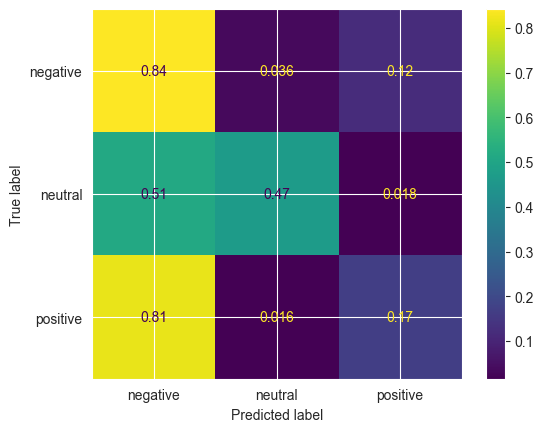

In [43]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [44]:
print(np.mean(cross_val_score(svc, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.5773507557306138


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    4.1s finished


LinearSVC

In [45]:
%%time

linear_svc_bcv = BayesSearchCV(estimator=LinearSVC(), search_spaces={
    "C": [x / 10 for x in range(1, 11, 1)],
    "max_iter": [x for x in range(10, 1000, 10)],
    "loss": ["hinge", "squared_hinge"],
}, scoring="f1_weighted", n_jobs=2, verbose=2)

linear_svc_bcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=LinearSVC(), n_jobs=2, scoring='f1_weighted',
              search_spaces={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0],
                             'loss': ['hinge', 'squared_hinge'],
                             'max_iter': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250, 260, 270, 280, 290, 300, ...]},
              verbose=2)

In [46]:
%%time
linear_svc_model = linear_svc_bcv.best_estimator_
linear_svc_model

CPU times: total: 0 ns
Wall time: 0 ns


LinearSVC(C=0.1, max_iter=400)

In [47]:
%%time
linear_svc_model.fit(X_train, y_train)

CPU times: total: 62.5 ms
Wall time: 42 ms


LinearSVC(C=0.1, max_iter=400)

In [48]:
y_pred = linear_svc_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.62      0.56      0.59      1707
     neutral       0.56      0.43      0.49       282
    positive       0.67      0.74      0.70      2011

    accuracy                           0.64      4000
   macro avg       0.61      0.58      0.59      4000
weighted avg       0.64      0.64      0.64      4000



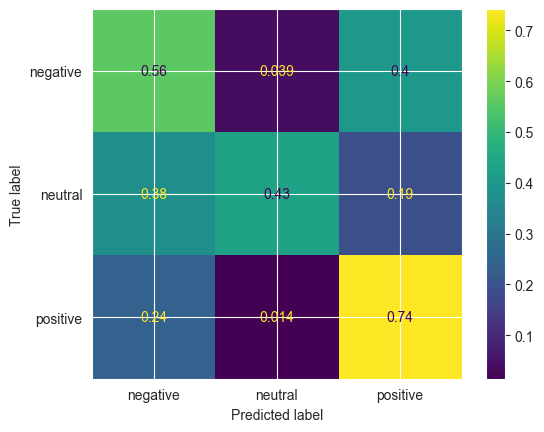

In [49]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [50]:
print(np.mean(cross_val_score(linear_svc_model, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

0.621205048265621


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


Логистическая регрессия

In [51]:
log_reg = LogisticRegression()

In [52]:
%%time
log_reg.fit(X_train, y_train)

CPU times: total: 312 ms
Wall time: 290 ms


LogisticRegression()

In [53]:
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.61      0.57      0.59      1707
     neutral       0.57      0.44      0.50       282
    positive       0.67      0.73      0.70      2011

    accuracy                           0.64      4000
   macro avg       0.62      0.58      0.59      4000
weighted avg       0.64      0.64      0.64      4000



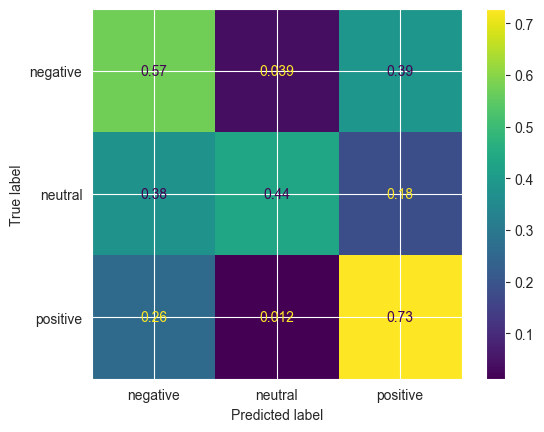

In [54]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [55]:
print(np.mean(cross_val_score(log_reg, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.6187922026974368


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.3s finished


K-ближайших соседей

In [56]:
knn_bcv = BayesSearchCV(estimator=KNeighborsClassifier(), search_spaces={
    "n_neighbors": [n for n in range(1, 21, 1)],
}, scoring="f1_weighted", n_jobs=2, verbose=2)

In [57]:
%%time
knn_bcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=KNeighborsClassifier(), n_jobs=2, scoring='f1_weighted',
              search_spaces={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                             12, 13, 14, 15, 16, 17, 18, 19,
                                             20]},
              verbose=2)

In [58]:
knn_model = knn_bcv.best_estimator_

In [59]:
knn_model

KNeighborsClassifier()

In [60]:
y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.50      0.59      0.54      1707
     neutral       0.65      0.05      0.09       282
    positive       0.59      0.57      0.58      2011

    accuracy                           0.54      4000
   macro avg       0.58      0.40      0.40      4000
weighted avg       0.55      0.54      0.53      4000



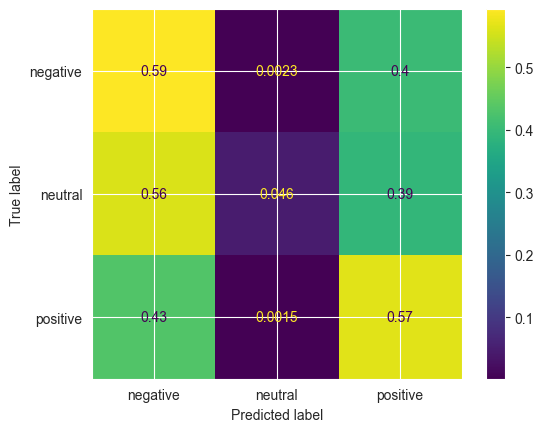

In [61]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [62]:
print(np.mean(cross_val_score(knn_model, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.5017398881102813


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.1s finished


Дерево решений

In [63]:
d_tree_bcv = BayesSearchCV(estimator=DecisionTreeClassifier(), search_spaces={
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [depth for depth in range(2, 500, 10)]
}, scoring="f1_weighted", n_jobs=2, verbose=2)

In [64]:
%%time
d_tree_bcv.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(estimator=DecisionTreeClassifier(), n_jobs=2,
              scoring='f1_weighted',
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': [2, 12, 22, 32, 42, 52, 62, 72, 82,
                                           92, 102, 112, 122, 132, 142, 152,
                                           162, 172, 182, 192, 202, 212, 222,
                                           232, 242, 252, 262, 272, 282, 292, ...],
                             'splitter': ['best', 'random']},
              verbose=2)

In [65]:
d_tree_model = d_tree_bcv.best_estimator_

In [66]:
d_tree_model

DecisionTreeClassifier(max_depth=352, splitter='random')

In [67]:
y_pred = d_tree_model.predict(X_test)
print(classification_report(y_test, d_tree_model.predict(X_test), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.59      0.50      0.54      1707
     neutral       0.47      0.38      0.42       282
    positive       0.63      0.73      0.68      2011

    accuracy                           0.61      4000
   macro avg       0.56      0.54      0.55      4000
weighted avg       0.60      0.61      0.60      4000



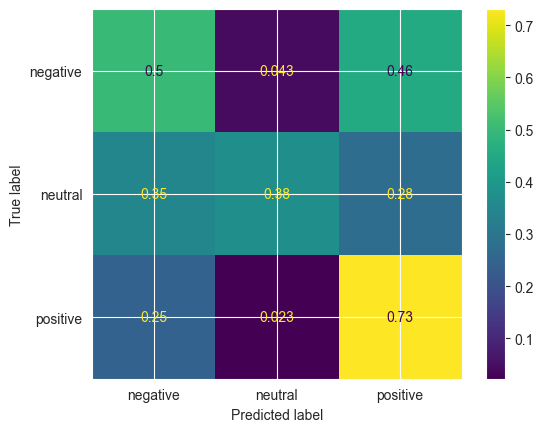

In [68]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()

In [69]:
print(np.mean(cross_val_score(d_tree_model, X_test, y_test, scoring="f1_weighted", cv=10, n_jobs=2, verbose=3)))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


0.5786001356683311


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    1.5s finished


Градиентный бустинг (CatBoost)

In [70]:
catboost_model = CatBoostClassifier(
    task_type="CPU",
    iterations=5000,
    od_wait=300,
    od_type="Iter",
    learning_rate=0.5,
    eval_metric="TotalF1",
)

In [71]:
x_train_, x_val_, y_train_, y_val_ = train_test_split(X_train, y_train, test_size=0.2)

In [72]:
catboost_model.fit(x_train_, y_train_, eval_set=(x_val_, y_val_), verbose=100, plot=True, use_best_model=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3791147	test: 0.3716119	best: 0.3716119 (0)	total: 234ms	remaining: 19m 29s
100:	learn: 0.6956244	test: 0.6085078	best: 0.6101050 (59)	total: 9.31s	remaining: 7m 31s
200:	learn: 0.7333044	test: 0.6173804	best: 0.6185812 (199)	total: 18.2s	remaining: 7m 13s
300:	learn: 0.7554156	test: 0.6174931	best: 0.6224644 (244)	total: 27.1s	remaining: 7m 2s
400:	learn: 0.7690422	test: 0.6200374	best: 0.6224644 (244)	total: 36.1s	remaining: 6m 53s
500:	learn: 0.7798148	test: 0.6157302	best: 0.6224644 (244)	total: 44.8s	remaining: 6m 42s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.6224644293
bestIteration = 244

Shrink model to first 245 iterations.


In [73]:
y_pred = catboost_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    negative       0.61      0.53      0.57      1707
     neutral       0.51      0.46      0.48       282
    positive       0.67      0.75      0.71      2011

    accuracy                           0.64      4000
   macro avg       0.60      0.58      0.59      4000
weighted avg       0.63      0.64      0.63      4000



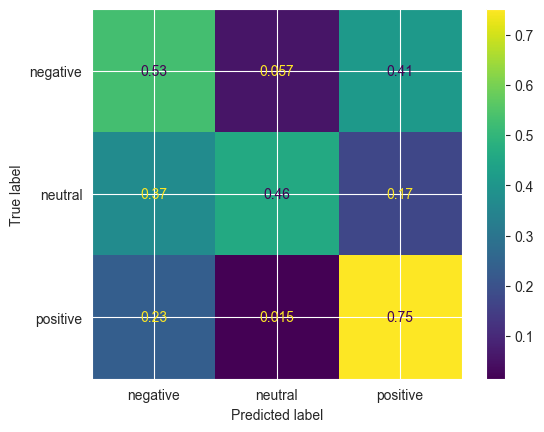

In [74]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_encoder.classes_).plot()